# btlflt.ipynb

There is much interest in using insect wimgbeat waveforms for automated monitoring of insect flight activity. [Perform a Google search for "insect wingbeat waveform"](https://www.google.com/search?client=ubuntu&channel=fs&q=insect+wingbeat+harmonics#vhid=RcBJqwjT8KH1GM&vssid=l) to see what I mean. 

Wingbeat waveforms can be recorded acoustically using a microphone, or optically using a photosensor. 

Here is the waveform and frequency spectrum of a mosquito I recorded way back in 1984 using a photodiode:

<img src="../images/example_waveform.png" width = "500px">

From [Moore, A. 1991. Artificial neural network trained to identify mosquitoes in flight.](https://www.researchgate.net/publication/226904676_Artificial_neural_network_trained_to_identify_mosquitoes_in_flight)

As you can see, spectral analysis of an insect wingbeat waveforms reveals that it contains a harmonic series consisting of the wingbeat frequency plus harmonics occurring at integer multiples of the wingbeat frequency.

I suggested that automated instrumentation could be developed to identify species of flying insects by recognizing spectral patterns formed by harmonics in much the same way in which the human brain and ear identifies musical instruments by recognizing distinct harmonic patterns in the sounds they produce (Moore, A. 1986).

Ever since doing this research 40 years ago, I have wondered about the origin of harmonics in optically recorded insect wingbeat waveforms. Here is an unpublished chart I made to help figure this out:

<img src="../images/waveform_chart.png">








In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output
from icecream import ic
from scipy.io import wavfile

from scipy.signal import butter, lfilter
from scipy.signal import freqz
from scipy.fft import rfft, rfftfreq

In [8]:
# Note: ```.gitignore``` includes VIDEOPATH and FRAMESDIR

VIDEO_PATH = 'video.mp4'
FRAMES_DIR = 'frames'
FIGURES_DIR = 'figures'
FIRST_FRAME_NUM = 1
LAST_FRAME_NUM = 718
SAMPLE_RATE = 6000

In [9]:
def create_square_wav(filepath:str, sample_rate:int, frequency:float, duration:float)->None:
    """ 
    Creates and saves a WAV file. Data saved as np.float32 ranging from -0.99 to 0.99
    """
    t = np.linspace(start=0., stop=duration,  num= int(duration * sample_rate), endpoint=False)
    square_wave = 0.99 * signal.square(2. * np.pi * frequency * t)
    wavfile.write(filepath, sample_rate, square_wave.astype(np.float32))

# create_square_wav(filepath='square_wave.wav', sample_rate=6000, frequency=100., duration=0.1)

In [10]:
def create_sine_wav(filepath:str, sample_rate:int, frequency:float, duration:float)->None:
    """ 
    Creates and saves a WAV file. Data saved as np.float32 ranging from -0.99 to 0.99
    """
    t = np.linspace(start=0, stop=duration, num=int(duration * sample_rate), endpoint=False)
    sine_wave = 0.99 * np.sin(2. * np.pi * frequency * t)
    wavfile.write(filepath, sample_rate, sine_wave.astype(np.float32))

# create_sine_wav(filepath='sine_wave.wav', sample_rate=6000, frequency=100., duration=0.1)

In [11]:
def convert_wav_from_float64_to_int16(src_wav_path, dest_wav_path):
    """ 
    Converts a WAV file from float64 to int16.
    This function facilitates using a WAV file in a web page with HTML code like:
    HTML example: <audio controls src="myfile.wav"></audio>
    This code does not work for 64-bit or 32-bit WAV files.
    """
    samplerate, data = wavfile.read('beetle.wav')
    if data.dtype == 'float64':
        maxint = np.iinfo(np.int16).max
        data = np.int16((maxint - 1) * data)   # rescales data values from (-1.0, 1.0) to (-32766, 32766)
        wavfile.write('beetle_16bit.wav', samplerate, data)
    else:
        print(f'WARNING: {src_wav_path} was not converted because source data.dtype is not float64')
        
# convert_wav_from_float64_to_int16('beetle.wav', 'beetle_16bit.wav')

In [12]:
# def calc_intensity_list(images_dir, first_frame_num, last_frame_num, normalize=True):
#     """
#     Calculates the average intensity of pixels within each frame of the video scene.
#     If normalize is True, intensity_list will be normalized so that mean is zero and range is -1 to 1.
#     """
#     intensity_list = []
#     for frame_num in range(first_frame_num, last_frame_num + 1):
#         image = cv2.imread(f'{images_dir}/{frame_num:04d}.png', cv2.IMREAD_GRAYSCALE)
#         intensity = np.mean(image)
#         intensity_list.append(intensity)
#     if normalize:
#         intensity_list = normalize_array(intensity_list)
#     return intensity_list

# calc_intensity_list(FRAMES_DIR, FIRST_FRAME_NUM, LAST_FRAME_NUM)

In [13]:
def normalize_array(arr):
    """ 
    Normalize array to range between -0.99 and 0.99 with a mean of 0.
    """ 
    arr = arr - np.mean(arr)
    scale_factor = 0.99 * max(abs(np.min(arr)), np.max(arr))
    return arr / scale_factor

# normalized_intensity_list = normalize_array(intensity_list)

In [14]:
def calc_intensity_time_series(images_dir:str, first_image:int, last_image:int, normalize:bool=True):
    """
    Calculates the average intensity of pixels within each frame of the video scene.
    If normalize is True, intensity_list will be normalized so that mean is zero and range is -1 to 1.
    """
    intensity_list = []
    for image_num in range(first_image, last_image + 1):
        image = cv2.imread(f'{images_dir}/{image_num:04d}.png', cv2.IMREAD_GRAYSCALE)
        intensity = np.mean(image)
        intensity_list.append(intensity)
    if normalize:
        intensity_list = normalize_array(intensity_list)
    return intensity_list

# calc_intensity_list(FRAMES_DIR, FIRST_FRAME_NUM, LAST_FRAME_NUM)

In [15]:
def plot_time_frequency(samplerate, data):
    """
    Plots a WAV file in time domain and frequency domain.
    The figure and its 2 sets of axes are returned so that these objects can be modified.
    """

    # Read WAV file
    ic(samplerate)
    ic(data.shape)
    duration = data.shape[0] / samplerate
    time = np.linspace(0., duration, data.shape[0])

    # Perform FFT and calculate frequency array
    power = np.abs(rfft(data))
    freq = rfftfreq(data.shape[0], 1/samplerate)
    
    # Create plot
    fig, (axt, axf) = plt.subplots(2, 1, constrained_layout=1, figsize=(7, 7))

    axt.plot(time, data, lw=1)
    axt.set_xlabel('time (s)')
    axt.set_ylabel('amplitude')

    axf.plot(freq, power, lw=1)
    axf.set_xlabel('frequency (Hz)')
    axf.set_ylabel('amplitude')
    axf.fill_between(freq, power)
    
    return fig, (axt, axf)

# wavefile_path = 'square_wave.wav'        
# fig, (axt, axf) = plot_time_frequency(wavefile_path)
# fig.suptitle(f'{wavefile_path} | fundamental freqency = ???')
# axf.set_xlim(0, 100)

In [16]:
def create_frame_intensity_figure(frame_num, seconds_list, intensity_list, frame_path, fig_path):
    """
    Creates an image with two subplots: the frame image and the intensity plot.
    """
 
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6))

    # Create image plot
    image = plt.imread(frame_path)
    ax1.imshow(image)
    ax1.set_title(f'Frame {frame_num} | normalized mean pixel intensity: {intensity_list[frame_num-1]:.2f}')
    ax1.axis('off')

    # Create a sample plot
    x = seconds_list[:frame_num]
    y = intensity_list[:frame_num]

    ax2.plot(x, y)
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel('normalized mean pixel intensity')
    ax2.set_xlim(min(seconds_list), max(seconds_list))
    ax2.set_ylim(-1, 1)

    # plt.tight_layout()
    
    # Save figure in a file
    fig.tight_layout
    fig.savefig(fig_path)
    plt.close(fig)
 
   
# create_frame_intensity_figure(1, seconds_list, intensity_list, 'frames/0001.png', 'test.png')

In [17]:
# from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def run():
    # import numpy as np
    # import matplotlib.pyplot as plt
    # from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 5000.0
    lowcut = 500.0
    highcut = 1250.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 0.05
    nsamples = int(T * fs)
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 600.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()
    
# run()


# MAIN PROGRAM

In [18]:
# Step 1: Download the video (best quality, no audio)

if os.path.exists(VIDEO_PATH):
    pass
else:
    command = f'yt-dlp -o {VIDEO_PATH} -f bestvideo https://www.youtube.com/watch?v=IUQSZHr9h9Q'
    os.system(command)

In [19]:
# Step 2: Extract frames from the video

if os.path.exists(FRAMES_DIR):
    pass
else:
    os.mkdir(FRAMES_DIR)
    command = f'ffmpeg -r 1 -i {VIDEO_PATH} -r 1 {FRAMES_DIR}/%04d.png'
    os.system(command)

In [25]:
# Process waveform

raw_data = calc_intensity_time_series(FRAMES_DIR, FIRST_FRAME_NUM, LAST_FRAME_NUM)
filtered_data = butter_bandpass_filter(data=raw_data, lowcut=30, highcut=2000, fs=SAMPLE_RATE, order=6)
windowed_filtered_data = np.hanning(len(filtered_data)) * filtered_data

ic| samplerate: 6000
ic| data.shape: (718,)


Text(0.5, 0.98, 'Windowed filtered data')

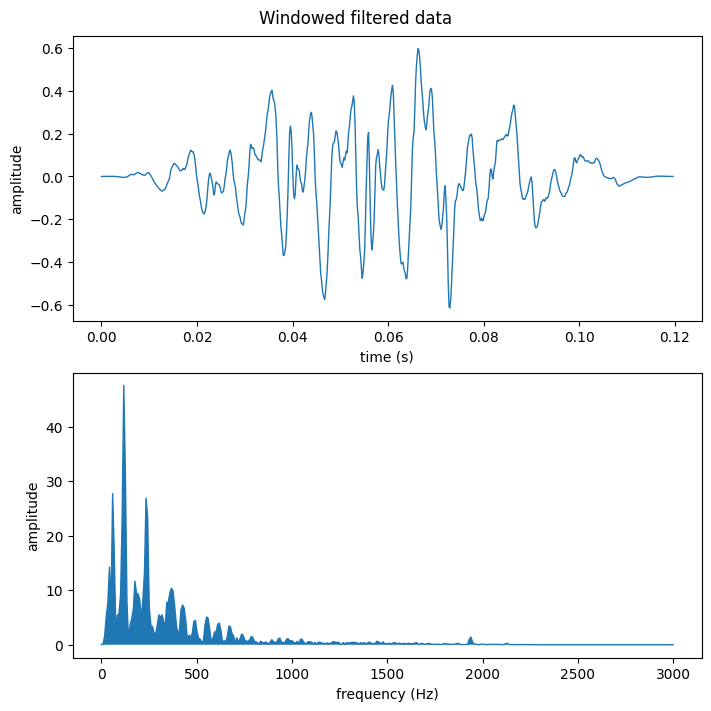

In [27]:
# Show results

fig, (axt, axf) = plot_time_frequency(SAMPLE_RATE, windowed_filtered_data)
fig.suptitle('Windowed filtered data')

In [29]:
# Code from https://stackoverflow.com/questions/61534687/how-to-calculate-pitch-fundamental-frequency-f-0-in-time-domain

import numpy as np
from scipy.io import wavfile
from scipy.signal import correlate, fftconvolve
from scipy.interpolate import interp1d

def parabolic(f, x):
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

def freq_from_autocorr(sig, fs):
    """
    Estimate frequency using autocorrelation
    """
    corr = correlate(sig, sig, mode='full')
    corr = corr[len(corr)//2:]
    d = np.diff(corr)
    start = np.nonzero(d > 0)[0][0]
    peak = np.argmax(corr[start:]) + start
    px, py = parabolic(corr, peak)

    return fs / px

fs = 6000.0
ic(freq_from_autocorr(raw_data, fs));
ic(freq_from_autocorr(filtered_data, fs));
ic(freq_from_autocorr(windowed_filtered_data, fs));

ic| freq_from_autocorr(raw_data, fs): np.float64(59.23565203970279)
ic| freq_from_autocorr(filtered_data, fs): np.float64(59.238071581839215)
ic| freq_from_autocorr(windowed_filtered_data, fs): np.float64(59.947328461747055)


In [26]:
# # Step 3: Create a plot of intensity vs time



# # create seconds_list which will be used for the x axis
# seconds_list = [i/FPS for i in range(LAST_FRAME_NUM)]

# # create intensity_list which will be used for the y axis
# intensity_list = calc_intensity_list(FRAMES_DIR, FIRST_FRAME_NUM, LAST_FRAME_NUM)

# # ensure that FIGURES_DIR exists
# os.makedirs(FIGURES_DIR, exist_ok=True)

# for frame_num in range(FIRST_FRAME_NUM, LAST_FRAME_NUM + 1):
#     create_frame_intensity_figure(
#         frame_num,
#         seconds_list, 
#         intensity_list, 
#         frame_path = f'{FRAMES_DIR}/{frame_num:04d}.png', 
#         fig_path = f'{FIGURES_DIR}/{frame_num:04d}.png'
#         )

In [15]:
# # Step 3a: Save intensity_list as a WAV file

# wavfile.write(filename='beetle.wav', rate=FPS, data=intensity_list)

In [11]:
print('FINISHED')

FINISHED
